## Training and Autodiff with PyTorch and Keras

This notebook looks behind the scences what is done in training using keras. We therefore show **autodiff** and how training can be done using autodiff for the **NLL** to do Gradient Descent. We will use the Banknote dataset for this example w/o hidden layers. 

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/01_fcnn_with_banknotes_training_details.ipynb)

#### Imports and Data

In the next two cells, we load all the required libraries and functions from keras and numpy. We also download the data with the 5 featues from the provided url.

In [73]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch # not needed yet

print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Keras_version: 3.8.0
torch_version: 2.5.1
keras backend: torch


In [74]:
# Load data from url
from urllib.request import urlopen
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
raw_data = urlopen(url)
dataset = np.loadtxt(raw_data, delimiter=",")
print(dataset.shape)

# Here we extract the two features and the labels of the dataset
X=dataset[:,[1,3]]
Y=dataset[:,4]
print(X.shape)
print(Y.shape)

(1372, 5)
(1372, 2)
(1372,)


## Autodiff Computation of the gradient w.r.t. to $w_1$

In deep learning frame works can be calculated automatically via backpropagation (chain rule). 

In [75]:
import torch

# Define the function
def predict_prob(x1, x2, w1, w2, b):
    return 1 / (1 + torch.exp(-(w1 * x1 + w2 * x2 + b)))

# Define inputs with requires_grad=True for w1
x1 = torch.tensor(1.0)
x2 = torch.tensor(2.3)
w1 = torch.tensor(0.3, requires_grad=True)
w2 = torch.tensor(0.2)
b = torch.tensor(1)

# Compute the probability
prob = predict_prob(x1, x2, w1, w2, b)

# Compute the derivative with respect to w1 via backpropagation
prob.backward()

# Print the results
print(f'Predicted probability: {prob.item()}')
print(f'd(prob)/d(w1): {w1.grad.item()}')

Predicted probability: 0.8532096743583679
d(prob)/d(w1): 0.1252429485321045


Calculation by hand using the chain rule:

$$
\frac{\partial \sigma(z)}{\partial w_1} = 
\frac{\partial \sigma(z)}{\partial z}  \cdot \frac{\partial z}{\partial w_1} 
,  \;\;\text{with} \frac{\partial \sigma(z)}{\partial z} = \sigma(z) \cdot (1-\sigma(z))
$$

In [76]:
x1=1.
x2=2.3
w1=0.3
w2=0.2
b=1.

def sig(x):
    return 1/(1+np.exp(-x))

z = w1*x1 + w2*x2 + b
sig(z) * (1 - sig(z)) * x1

0.12524293594237704

##  Training using Keras

He used the Keras library to train the model

#### Definition of a NN with only one neuron after the input


In [77]:
model = Sequential() # starts the definition of the network
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))  # adds a new layer to the network with a single neuron
                                                            # The input is a tensor of size (batch_size, 2), since we don’t specify the Batch Size now, we use None as a placeholder

sgd = SGD(learning_rate=0.10)

# Compile the model
model.compile(loss='binary_crossentropy', # compile model, which ends the definition of the model
              optimizer=sgd,              # using the stochastic gradient descent optimizer
              metrics=['accuracy'])

/Users/oli/Documents/GitHub/dlwbl_eth25/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In the next cell, we train the network. In other words, we tune the parameters that were initialized randomly with stochastic gradient descent to minimize our loss function (the binary crossentropy). We set the batchsize to 128 per updatestep and train for 400 epochs.

In [78]:
# Training of the network
history = model.fit(X, Y,                           # training of the model using the training data stored in X and Y for 4100 epochs
          epochs=100,                               # for 400 epochs
          batch_size=128,                           # fix the batch size to 128 examples
          verbose=0)

Let's look at the so called leraning curve, we plot the accuracy and the loss vs the epochs. You can see that after 100 epochs, we predict around 70% of our data correct and have a loss around 0.51 (these values can vary from run to run).

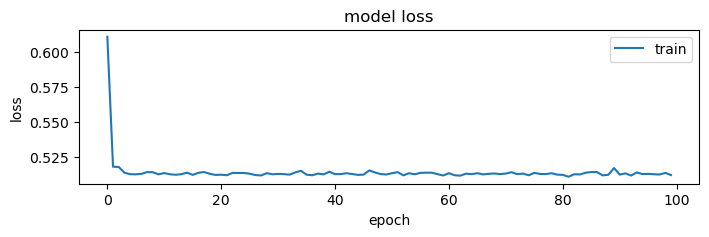

After training: Weights: [[-0.34062374 -0.5209293 ]]  Biases: [-0.18055691] Final loss: 0.5120294094085693


In [79]:
# plot the development of the accuracy and the loss during the training
plt.figure(figsize=(8, 2))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# Get the weights and biases from the Keras model
weights, biases = model.get_weights()

print(f'After training: Weights: {weights.T}  Biases: {biases} Final loss: {history.history["loss"][-1]}')

## Training using PyTorch

Now we do the train by ourself by using autodiff.

In [80]:
# Convert to torch Tensors
X = torch.tensor(X, dtype=torch.float32)   # shape (1372, 2)
Y = torch.tensor(Y, dtype=torch.float32)   # shape (1372,)

In [81]:
# Initialize parameters
W = torch.zeros(2, 1, requires_grad=True)  # shape (2,1)
b = torch.zeros(1, requires_grad=True)     # shape (1,)

def predict_prob(X, W, b):
    """
    Logistic regression forward pass:
    X: shape (N, 2)
    W: shape (2,1)
    b: scalar
    returns: predicted probabilities in shape (N,)
    """
    z = X @ W + b  # Matrix multiplication (N,2) @ (2,1) -> (N,1)
    return 1 / (1 + torch.exp(-z)).squeeze(1)  # Output shape (N,)

ps = predict_prob(X, W, b)
ps.shape


torch.Size([1372])

In [82]:
def NLL(X, Y, W, b):
    """
    Negative Log-Likelihood (binary cross-entropy) for logistic regression
    X: shape (N, 2)
    Y: shape (N,) with 0/1
    """
    eps = 1e-7
    p = predict_prob(X, W, b).clamp(eps, 1 - eps)   # numerically safe
    loss = - (Y * torch.log(p) + (1 - Y) * torch.log(1 - p)).mean()
    return loss


In [83]:
learning_rate = 0.1
n_epochs = 100
loss_history = []

for epoch in range(n_epochs):
    # 1) Forward + loss
    loss = NLL(X, Y, W, b)
    loss_history.append(loss.item())
    
    # 2) Backprop to compute dLoss/dW and dLoss/db
    loss.backward()
    
    # 3) Gradient descent update (manual)
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
    
    # 4) Zero out gradients for next iteration
    W.grad.zero_()
    b.grad.zero_()

# Final result
print(f"Final W: {W.T.detach().numpy()},  b: {b.item():.3f}")
print(f"Final loss: {loss_history[-1]:.4f}")

Final W: [[-0.32734278 -0.50651157]],  b: -0.108
Final loss: 0.5118


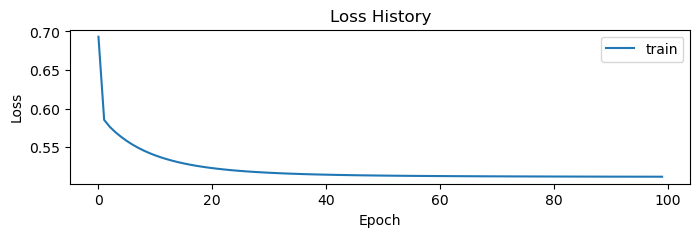

In [84]:
plt.figure(figsize=(8, 2))
plt.plot(loss_history)
plt.title('Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [85]:
print(f'Weights: {W.T.detach().numpy()} Biases: {b.item()}  Final loss: {loss_history[-1]}')

Weights: [[-0.32734278 -0.50651157]] Biases: -0.10773194581270218  Final loss: 0.5117965340614319
